학습목표

- 파이썬 코드를 저수준에서 동작하도록 만드는 방법
- JIT 컴파일러와 AOT 컴파일러의 차이점
- 순수 파이썬 코드보다 컴파일된 파있너 코드가 빠른 이유
- 타입 어노테이션이 파이썬 코드의 성능에 도움이 되는 이유
- C 나 포트란으로 파이썬 모듈을 작성하는 방법
- C나 포트란으로 작성된 라이브러리르 파이썬에서 사용하는 방법

### 7.1 가능한 속도 개선의 종류

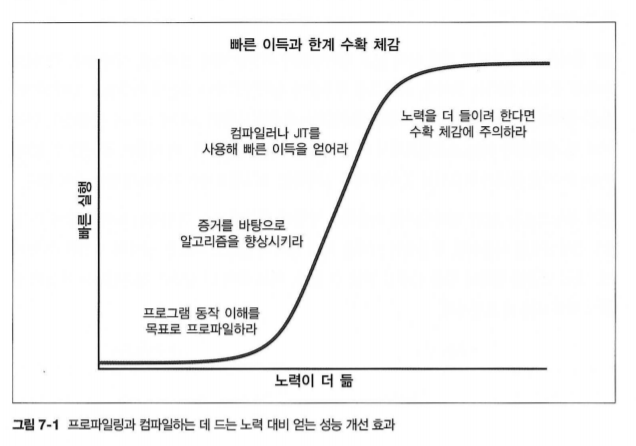

### 7.2 JIT 대 AOT 컴파일러

AOT: ahead of time -> Cython
JIT: just in time -> Numba, Pypy

콜드 스타트등의 문제로 AOT를 추천

### 7.3 타입 정보가 실행 속도에 영향을 주는 이유

파이썬은 변수가 어떤 타입이라도 참조할 수 있고, 코드 어디에서든 참조하는 객체 타입을 변경할 수 있는 동적 타입 언어이다.
직접 기계어 수준으로 내려가 계산하면 오버헤드를 초래하는 고수준 파이썬 객체보다 훨씬 속도가 빨라진다.

### 7.4 C 컴파일러 사용하기

gcc, gcc++ 사용해 C언어 컴파일하기

c 컴파일 gcc -o [출력파일명] [cpp 파일명]

### 7.5 줄리아 집합 예제 다시보기

1000 * 1000 크기에 maxiter=300 -> 8sec

In [2]:
# CPU를 가장 많이 사용하는 부분은 output 리스트를 계산하는 내부 루프

def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while n < maxiter and abs(z) < 2:
            z = z * z + c
            n += 1
        output[i] = n
    return output

### 7.6 사이썬

C 기반 컴파일
타입을 명시한 파이썬 코드를 컴파일된 확장 모츌로 변경해주는 컴파일러: cdef 로 타입을 고정

- 파이썬 코드
- 컴파일된 .pyx 파일
- 확장 모듈을 작성하기 위해 사이썬을 호출하는 setup.py파일



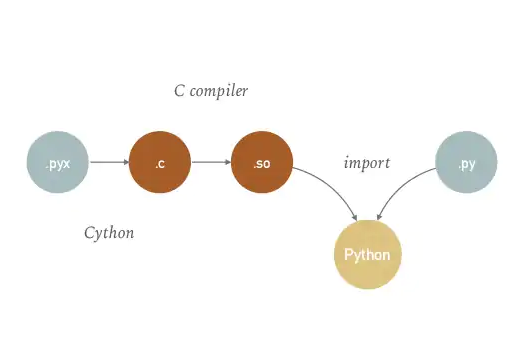

In [ ]:
# 싸이썬의 예제
# 필요한 파일 중 .pyx

@profile
def calculate_z(int maxiter, zs, cs):   <--------------- 함수 variable 에도 타입을 넣고
    """Calculate output list using Julia update rule"""
    cdef unsigned int i, n <--------------- cdef 타입 으로 타입 픽스
    cdef double complex z, c
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while n < maxiter and (z.real * z.real + z.imag * z.imag) < 4:
            z = z * z + c
            n += 1
        output[i] = n
    return output

In [ ]:
# 사이썬으로 순수 파이썬 코드 컴파일하기

cd /high_performance_python_2e/07_compiling/julia/cython/cpython
$ python setup.py build_ext --inplace
$ py julia1.py 

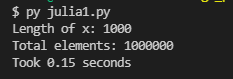

### 7.7 pyximport

setup.py 없이 cpython 실행

In [3]:
# 파이썬 코드 위에 추가
import pyximport 
pyximport.install(language_level=3)
import cythonfn

(None, <pyximport.pyximport.PyxImporter at 0x1d403f2a4f0>)

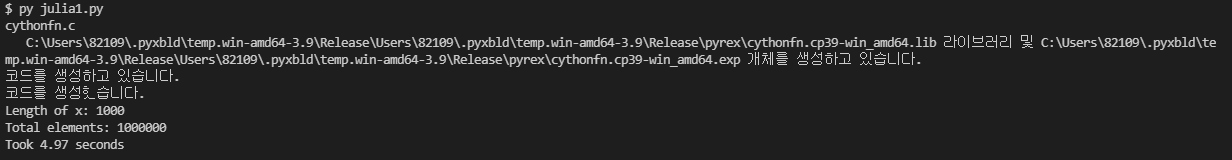

1) 코드 블록을 분석하기 위한 시각화 자료 사이썬 어노테이션: cpython

일반적으로 CPU 시간을 많이 소모하는 코드 
- 내부루프
- list, array 등을 역참조 하는 경우
- 수학계산

아래의 그림을 보면 하얀 부분이 native 코드로 연산이 적은 부분이다.

타입 어노테이션을 붙이면 짙은 색에서 하얀색으로 바뀐다.

cython 으로도 확인할 수 있지만 line_profiler로도 확인할 수 있다.

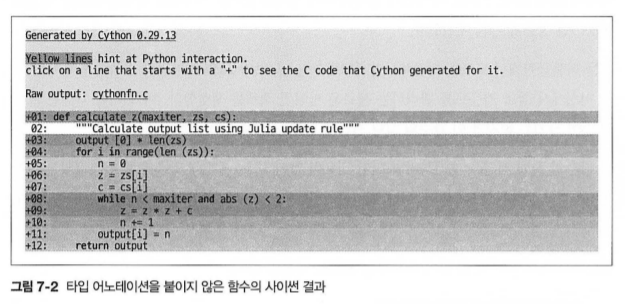

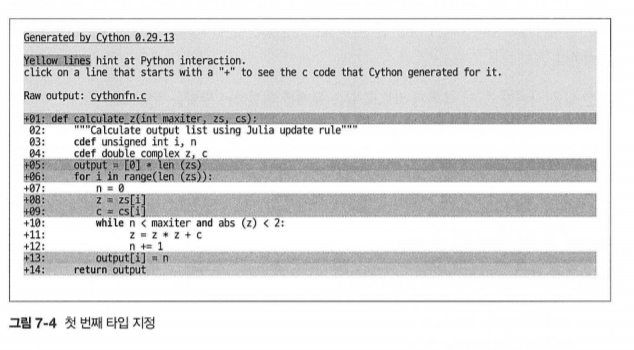

2) 타입 어노테이션 추가하기

.pyx파일에 cdef 문법을 사용해 몇가지 기본 타입을 지정할 수 있다.
단 list에는 사용하더라도 실직적으로 효과가 없다. 

In [ ]:
@profile
def calculate_z(int maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    cdef unsigned int i, n <----- 추가한 부분
    cdef double complex z, c <----- 추가한 부분
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while n < maxiter and (z.real * z.real + z.imag * z.imag) < 4:
            z = z * z + c
            n += 1
        output[i] = n
    return output


강도절감

In [ ]:
# 강도절감

abs() 부분을 while n < maxiter and (z.real * z.real + z.imag * z.imag) < 4: 같이 표현할 수 있다.

경계 분석

리스트 주소를 찾을 때 경계 검사(인덱스 검사)를 하지 않는 것. 파이썬 첫머리에 주석을 추가하면 된다

In [ ]:
#cython: boundcheck=False

### 7.8 사이썬과 넘파이

list의 객체는 어디에든 존재할 수 있기 때문에 역참조(단편화)에 따른 부가비용이 따른다.

반면 배열 객체는 RAM에 연속적으로 저장하기 떄문에 주소계산이 빠르다.

array 객체를 미리 예측할 수 있는 패턴으로 이터레이션 한다면 파이썬에서 다음 주소를 요청하는 것이 아니라 직접 다음 주소를 계산해 접근할 수 있다.

In [ ]:
from cython.parallel import parallel, prange
import numpy as np  <----------- numpy를 이용해서 객체의 타입을 고정하고
cimport numpy as np

def calculate_z(int maxiter, double complex[:] zs, double complex[:] cs):<----------- 타입을 넣고 자료구조도 변형해서 numpy로  array를 표현
    """Calculate output list using Julia update rule"""
    cdef unsigned int i, length
    cdef double complex z, c
    cdef int[:] output = np.empty(len(zs), dtype=np.int32) <----------- 
    length = len(zs)
    with nogil, parallel():
        for i in prange(length, schedule="guided"):
            z = zs[i]
            c = cs[i]
            output[i] = 0
            while output[i] < maxiter and (z.real * z.real + z.imag * z.imag) < 4:<----------- abs()함수를 인라이닝해서 빠르게 만듦
                z = z * z + c
                output[i] += 1
    return output

1) OpenMP로 병렬화

- OpenMP은 C, C++ 포트란에서 병렬 실행과 메모리 공유를 지원하는 API
- 적절히 작성된 C 코드를 컴파일러 수준에서 병렬화해준다.
- GIL이 비활성화 된다

In [ ]:
# 사용법

# .pyx 파일에 추가
from cython.parallel import prange <----------- 

# setup.py에 컴파일러와 링커 플래그를 추가
ext_modules = [Extension(
      "cythonfn",
      ["cythonfn.pyx"], 
      extra_compile_args=['-fopenmp'], 
      extra_link_args=['-fopenmp'],
      )]

### 7.9 Numba

- LLVM 기반 컴파일
- numpy 코드에 특화되 JIT

In [ ]:
# jit 데커레이터로 구현한다
@jit(nopython=False)

# 병렬화 추가 == openMP 사용
@jit(nopython=False, parallel=True)

# 팬더스에 적용
ols_numba = jit(함수, nopython=True)

In [ ]:
@jit(nopython=False)
def calculate_z(maxiter, zs, cs, output):
    """Calculate output list using Julia update rule"""
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while n < maxiter and abs(z) < 2:
            z = z * z + c
            n += 1
        output[i] = n
    #return output

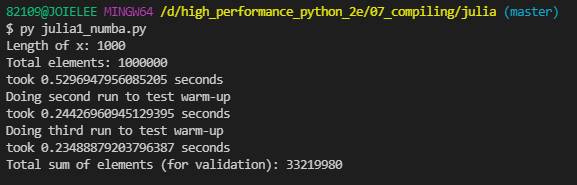

### 7.10 Pypy: 파이썬으로 파이썬 인터프리터를 제작해보자

- Rpython: Restricted Python, JIT 기능을 가지고 있다 -> binary 파일이 나온다.
- RPyhton: 파이썬으로 구현한 인터프리터로 GIL이 없어진다.

- 파이썬 가상머신을 대체하는 내장 JIT 컴파일러를 포함
- C파이썬을 완전히 대체할 수 있다
- 순수 파이썬을 아무 수정없이 그대로 사용할 수 있다
- multiprocessing이 가능하다
- RAM 을 많이 사용하는 단점이 있다

1) GC의 차이

- reference counting 대신 mark and sweep이라는 기법 사용
- 이로인해 GIL을 사용하지 않게 됨

2) Pypy 실행 및 모듈 설치

### 7.11 속도 향상 결과 정리

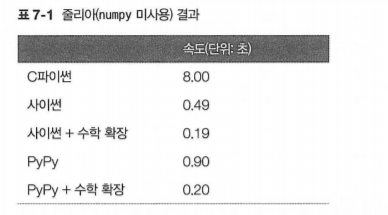

### 7.12 각 기술의 사용 시점

- Cython: numpy 와 함께 사용하기에 좋다. 
- Numba: 한계 있음
- Pypy: 순수 파이썬에 사용하기 좋다.

### 7.13 GPU

- 산술연산에 빠르다.
- pytorch

In [ ]:
# GPU 기본 프로파일링
# 소비전력 power usage: 얼마나 쉬지 않는 상태인지 지표 => 대용량 데이터를 업로드하는 과정에서 낮아질 수 있다. tensor.pin_memory()이용하기
# GPU utilization : 계산 능력 상태, 높을 수록 연산을 많이 하고 있다는 의미

nvidia-smi

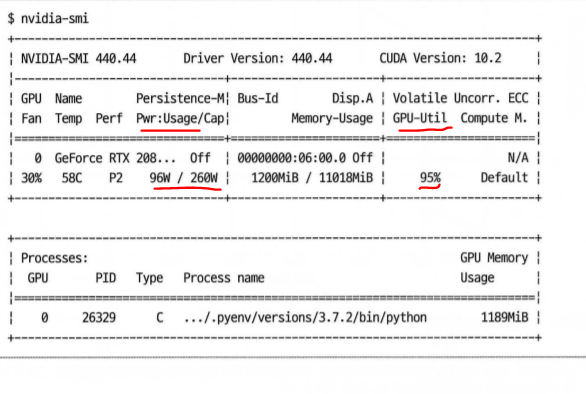

In [8]:
# 파이토치 에서 제공하는 프로파일링 도구

!python -m torch.utils.bottleneck 

D:\anaconda\python.exe: Error while finding module specification for 'torch.utils.bottleneck' (ModuleNotFoundError: No module named 'torch')


### 7.14 외부 함수 인터페이스

이종 언어간 인터페이스를 이용해 둘 이상의 언어를 이어붙이면, 하나의 언어로는 표현하기 힘든 부분까지도 표현할 수 있게 돼 프로그래밍 언어의 표현력을 한층 상승시킬수 있게 된다.

1) ctypes

이미 존재하는 함수의 원형을 파이썬 환경에 적절하도록 고쳐 사용할 수 있다

In [10]:
# 윈도 환경에서 msvcrt.dll의 printf 함수를 호출하는 예

from ctypes import *
printf = cdll.msvcrt.printf
printf("hello world\n")

1

2) cffi

In [12]:
from cffi import FFI

ffi = FFI()
ffi.set_source('mylib', r'''
#include <stdio.h>
''')
ffi.cdef(r'''
void puts(const char *);
''')
ffi.compile(verbose=True)

generating .\mylib.c
the current directory is 'C:\\Users\\82109\\Desktop'
running build_ext
building 'mylib' extension
creating Release
C:\Program Files (x86)\Microsoft Visual Studio\2017\BuildTools\VC\Tools\MSVC\14.16.27023\bin\HostX86\x64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -ID:\anaconda\include -ID:\anaconda\include "-IC:\Program Files (x86)\Microsoft Visual Studio\2017\BuildTools\VC\Tools\MSVC\14.16.27023\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\shared" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\winrt" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\cppwinrt" /Tcmylib.c /Fo.\Release\mylib.obj
C:\Program Files (x86)\Microsoft Visual Studio\2017\BuildTools\VC\Tools\MSVC\14.16.27023\bin\HostX86\x64\link.exe /nologo /INCREMENTAL:NO /LTCG /DLL /MANIFEST:EMBED,ID=2 /MANIFESTUAC:NO /

'C:\\Users\\82109\\Desktop\\mylib.cp38-win_amd64.pyd'

In [13]:
import mylib

mylib.lib.puts(b'Hello, world!')

3) f2py

파이썬과 포트란 언어 사이의 연결을 제공

4) C 파이썬 모듈

C 파이썬 API 수준에서 C 파이썬 모듈을 작성